<a href="https://colab.research.google.com/github/haldrianmit/CatKit/blob/master/advanced_kinetics_qm_tut_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Install Conda Colab**
# @markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
# @markdown This will take a few minutes.
# install dependencies
%%capture
!mamba install -c anaconda intel-openmp
!conda config --add channels http://conda.anaconda.org/psi4
!mamba install psi4 resp -c conda-forge/label/libint_dev -c conda-forge

import os
import psi4
import resp
import numpy as np

In [ ]:
def optfreq(mol, method, basis_set):
    #First, do the optimization.
    psi4.optimize(method + '/' + basis_set , molecule=mol)

    #Then compute the frequencies using this geometry.
    mol_e, mol_wfn = psi4.frequency(method + '/' + basis_set , molecule = mol, return_wfn=True)

    #Next do the vibrational analysis.
    mol_vibinfo = psi4.driver.vibanal_wfn(mol_wfn) # do the vibrational analysis for the molecule.
    return mol_e, mol_wfn, mol_vibinfo

def thermocalc(mol, mol_vibinfo, T, P, mol_e, mol_shape = None):
    #Compute the molar mass for the molecule:
    mol_mass = 0
    for iat in range(mol.natom()):
        mol_mass += mol.mass(iat)

    #Get all the other molecular information required for the thermo_calculations.
    mol_mult = mol.multiplicity()
    mol_sigma = mol.rotational_symmetry_number()
    mol_rot_constants = np.asarray(mol.rotational_constants())

    #Next compute the thermo:
    mol_therminfo_T = psi4.driver.qcdb.vib.thermo(mol_vibinfo, T, P, mol_mult, mol_mass, mol_e, mol_sigma, mol_rot_constants , mol_shape)
    mol_thermdict_T = mol_therminfo_T[0]

    return mol_thermdict_T

In [ ]:
psi4.set_memory('1GB')

co = psi4.geometry("""
C       -3.69588       -0.86528        0.00000
O       -3.82425        0.18390        0.00000

""")

h2 = psi4.geometry("""
H       -4.75453       -0.43223        0.00000
H       -4.76313       -1.14018        0.00000

""")

formaldehyde = psi4.geometry("""
C         -4.91148       -0.76497        0.02838
O         -4.94682        0.45913        0.02244
H         -5.82601       -1.37924        0.03603
H         -3.96304       -1.32551        0.02644
units angstrom

no_reorient
symmetry c1
""")

In [ ]:
psi4.set_output_file('co_hf_1.dat')
psi4.set_options({'opt_type':'min','soscf':'true'})
co_hf_1_e, co_hf_1_wfn, co_hf_1_vibinfo = optfreq(co, 'scf', 'STO-3G')

psi4.set_output_file('h2_hf_1.dat')
h2_hf_1_e, h2_hf_1_wfn, h2_hf_1_vibinfo = optfreq(h2, 'scf','STO-3G')

psi4.set_output_file('h2co_hf_1.dat')
formald_hf_1_e, formald_hf_1_wfn, formald_hf_1_vibinfo = optfreq(formaldehyde, 'scf', 'STO-3G')

Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!


In [ ]:
psi4.set_output_file('co_hf_2.dat')
psi4.set_options({'opt_type':'min','soscf':'true'})
co_hf_2_e, co_hf_2_wfn, co_hf_2_vibinfo = optfreq(co, 'scf', '6-31G')

psi4.set_output_file('h2_hf_2.dat')
h2_hf_2_e, h2_hf_2_wfn, h2_hf_2_vibinfo = optfreq(h2, 'scf','6-31G')

psi4.set_output_file('h2co_hf_2.dat')
formald_hf_2_e, formald_hf_2_wfn, formald_hf_2_vibinfo = optfreq(formaldehyde, 'scf', '6-31G')

Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!


In [ ]:
psi4.set_output_file('co_hf_3.dat')
psi4.set_options({'opt_type':'min','soscf':'true'})
co_hf_3_e, co_hf_3_wfn, co_hf_3_vibinfo = optfreq(co, 'scf', '6-311++G(d,p)')

psi4.set_output_file('h2_hf_3.dat')
h2_hf_3_e, h2_hf_3_wfn, h2_hf_3_vibinfo = optfreq(h2, 'scf','6-311++G(d,p)')

psi4.set_output_file('h2co_hf_3.dat')
formald_hf_3_e, formald_hf_3_wfn, formald_hf_3_vibinfo = optfreq(formaldehyde, 'scf', '6-311++G(d,p)')

Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!


In [ ]:
#Now to move on to kinetics. To compute a rate constant, we need a guess transition state for formaldehyde decomposition.
#Getting a guess transition state geometry is often the most painful part (if it exists at all). In this case, this reaction is well-known so guesses are not too hard to derive.
ts_decomp = psi4.geometry("""
C         -3.74743       -2.49829        0.02136
O         -4.24478       -1.47338       -0.19728
H         -3.48515       -3.56003       -0.09660
H         -3.96108       -3.63243       -1.28600
units angstrom

no_reorient
symmetry c1
""")


print('Optimizing the transition state at HF/STO-3G')
print('========================================================')
#Let's try optimizing this structure and seeing if it works. We will want to eventually visualize this, so I will set an output file here:
psi4.core.set_output_file('ts_hf_1.dat', False)
psi4.set_options({"opt_type" : 'ts','full_hess_every':10,'geom_maxiter':200,'soscf':'false'}) #we want to tell psi4 to optimize to a transition state and not a minima. ,
ts_hf_1_e, ts_hf_1_wfn,ts_hf_1_vibinfo = optfreq(ts_decomp,'scf','sto-3g')
print('TS Energy: {} Hartree'.format(ts_hf_1_e))

Optimizing the transition state at HF/STO-3G
Optimizer: Optimization complete!
TS Energy: -112.12930353924304 Hartree


In [ ]:
print('Optimizing the transition state at HF/6-31G')
print('========================================================')
#Let's try optimizing this structure and seeing if it works. We will want to eventually visualize this, so I will set an output file here:
psi4.core.set_output_file('ts_hf_2.dat', False)
psi4.set_options({"opt_type" : 'ts','full_hess_every':10,'geom_maxiter':200,'soscf':'false'}) #we want to tell psi4 to optimize to a transition state and not a minima. ,
ts_hf_2_e, ts_hf_2_wfn,ts_hf_2_vibinfo = optfreq(ts_decomp,'scf','6-31G')
print('TS Energy: {} Hartree'.format(ts_hf_2_e))

Optimizing the transition state at HF/6-31G
Optimizer: Optimization complete!
TS Energy: -113.62977761039664 Hartree


In [ ]:
print('Optimizing the transition state at HF/6-311++G(d,p)')
print('========================================================')
#Let's try optimizing this structure and seeing if it works. We will want to eventually visualize this, so I will set an output file here:
psi4.core.set_output_file('ts_hf_3.dat', False)
psi4.set_options({"opt_type" : 'ts','full_hess_every':10,'geom_maxiter':200,'soscf':'false'}) #we want to tell psi4 to optimize to a transition state and not a minima. ,
ts_hf_3_e, ts_hf_3_wfn,ts_hf_3_vibinfo = optfreq(ts_decomp,'scf','6-311++G(d,p)')
print('TS Energy: {} Hartree'.format(ts_hf_3_e))
clonef = ts_hf_3_wfn.molecule().clone()
cloneb = ts_hf_3_wfn.molecule().clone()

Optimizing the transition state at HF/6-311++G(d,p)
Optimizer: Optimization complete!
TS Energy: -113.74091629889745 Hartree


In [ ]:
#The transition state optimizations were all successful from a convergence standpoint, but how do we check that the transition state is reasonable?
#A transition state should have only one imaginary (may show a negative) frequency that corresponds to the reaction in question.
#There is also a calculation known as an IRC that uses a mass-weighted descent algorithm to traverse the PES along the reaction coordinate starting from the TS until it reaches a minima on either side.
#These minima should correspond to the reactants and products of the reaction.
print('Doing the forward IRC at HF/6-311++G(d,p)')
print('========================================================')
psi4.core.set_output_file('irc_hf_forward.dat', False)
psi4.set_options({"opt_type" : 'irc', "full_hess_every": 10, "irc_direction": "forward", "soscf": 'false','geom_maxiter':100}) #Do an IRC calculation to check the transition state is reasonable.
irc_hf_f,wfn_irc_hf_f = psi4.optimize('scf/6-311+G(d,p)',return_wfn='yes', molecule=clonef)

Doing the forward IRC at HF/6-311++G(d,p)
Optimizer: Optimization complete!
[{'step_number': 0, 'q': [2.130267348220072, 2.126400730253009, 2.226683868659227, 1.6524842514036113, 2.760419591168313, 0.0], 'x': [[0.4441354135900945, -0.8770575551433982, 0.31527926014764374], [-0.4041243899430167, 1.0308320786082237, -0.10715585442694522], [1.0012629807333582, -2.904064249712816, -0.004771985312078607], [0.12424007135233969, -3.013014838446507, -2.048562981618369]], 'f_q': [-0.001442290828613217, 0.025133083964086273, -0.0032763526126868975, 0.02646736036632045, -0.02392950414564158, -1.3915550286853229e-08], 'f_x': [0.005964584644019823, 0.028245517658634346, 0.0351344071708691, -0.002675042599055576, -0.0049733598103666714, -0.009816952511019713, -0.00808801210479402, -0.01211133077245599, -0.027422861732637742, 0.004798470059829774, -0.011160827075811683, 0.0021054070727883484], 'energy': -113.7441833419937, 'q_pivot': [2.1269221983949924, 2.163965702670081, 2.132259740590427, 1.697649

In [ ]:
print('Doing the backward IRC at HF/6-311++G(d,p)')
print('========================================================')
psi4.core.set_output_file('irc_hf_backward.dat', False)
psi4.set_options({"opt_type" : 'irc', "full_hess_every": 10, "irc_direction": "backward", 'soscf': "false", "PRINT_TRAJECTORY_XYZ_FILE":"true",'geom_maxiter':200}) #Do an IRC calculation to check the transition state is reasonable.
irc_hf_b,wfn_irc_hf_b =  psi4.optimize('scf/6-311++G(d,p)',return_wfn='yes', molecule=cloneb)

Doing the backward IRC at HF/6-311++G(d,p)
Optimizer: Optimization complete!
[{'step_number': 0, 'q': [2.137382183855708, 2.0750041280275893, 2.3954084848908437, 1.5525663574498334, 2.8605054886676133, 0.0], 'x': [[0.437132216232608, -0.893814806624627, 0.28668910900924494], [-0.3992193563926966, 1.036358581197516, -0.09192591944864206], [1.0453675342316564, -2.8706236077839926, 0.11959963319163719], [0.08567494708809044, -2.9346393643727042, -2.074226688689179]], 'f_q': [-5.954343243621411e-05, -1.069202738488541e-06, 2.5033104003906418e-05, 1.0848750481879683e-05, -8.984878088742331e-06, -9.200749854353066e-08], 'f_x': [-1.821980750286225e-05, 5.437031619118565e-05, 2.0550879060040115e-06, 2.2179283078425395e-05, -5.5013346966826326e-05, 6.687782818226606e-06, 4.8084932678069395e-06, 5.641155246768593e-06, 1.4609021720637094e-05, -8.767968843370086e-06, -4.9981244711279214e-06, -2.335189244486771e-05], 'energy': -113.74091629893344, 'q_pivot': [2.1409455492309895, 2.049295148177957, 

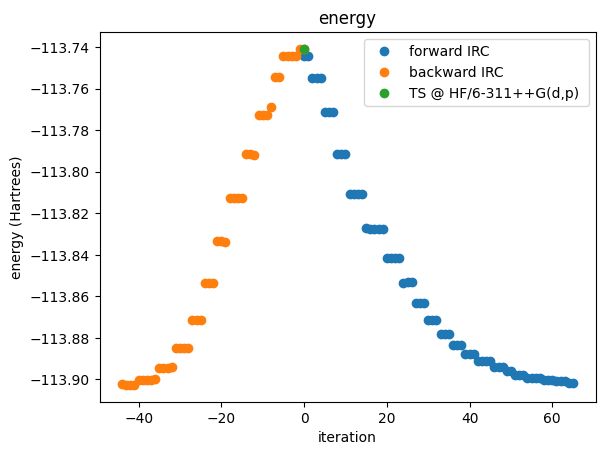

In [ ]:
from matplotlib import pyplot as plt
def plot_energy(filename):
    """
    Function to find the energy in a psi4 optimization file.

    Usage: plot_energy(filename)

    Inputs: name of psi4 output file from geometry optimization calclaultion
    filename: name

    Output: list of energy values from each optimization step
    """

    with open(filename) as f:
        lines = f.readlines()
        #energy_string = 'Current energy'
        energy_values = [ float(line.split()[3]) for line in lines if line.strip().startswith('@DF-RHF Final Energy') ]
        return energy_values
energy_values_f = plot_energy('irc_hf_forward.dat')
energy_values_b = plot_energy('irc_hf_backward.dat')
stepsf = len(energy_values_f)
stepsb = len(energy_values_b)

# plot the energies at each iteration
plt.figure()
plt.plot(range(stepsf),energy_values_f,'o')
plt.plot([x*-1 for x in range(stepsb)],energy_values_b,'o')
plt.plot(0,ts_hf_3_e,'o')


plt.legend(['forward IRC','backward IRC','TS @ HF/6-311++G(d,p) '])
plt.xlabel("iteration")
plt.ylabel("energy (Hartrees)")
plt.title('energy')
plt.savefig(F'IRC.png')


In [ ]:
#now let's try DFT
psi4.set_memory('1 GB')

co = psi4.geometry("""
C       -3.69588       -0.86528        0.00000
O       -3.82425        0.18390        0.00000

""")

h2 = psi4.geometry("""
H       -4.75453       -0.43223        0.00000
H       -4.76313       -1.14018        0.00000

""")

formaldehyde = psi4.geometry("""
C         -4.91148       -0.76497        0.02838
O         -4.94682        0.45913        0.02244
H         -5.82601       -1.37924        0.03603
H         -3.96304       -1.32551        0.02644
units angstrom

no_reorient
symmetry c1
""")


In [ ]:
# minima geometry optimizations with B3LYP/STO-3G (tiny basis set)

psi4.set_output_file('co_b3lyp_1.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
co_b3lyp_1_e, co_b3lyp_1_wfn, co_b3lyp_1_vibinfo = optfreq(co, 'b3lyp', 'STO-3G')
print('CO energy: {} Hartree'.format(co_b3lyp_1_e))

psi4.set_output_file('h2_b3lyp_1.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
h2_b3lyp_1_e, h2_b3lyp_1_wfn, h2_b3lyp_1_vibinfo = optfreq(h2, 'b3lyp','STO-3G')
print('H2 energy: {} Hartree'.format(h2_b3lyp_1_e))

psi4.set_output_file('h2co_b3lyp_1.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
formald_b3lyp_1_e, formald_b3lyp_1_wfn, formald_b3lyp_1_vibinfo = optfreq(formaldehyde, 'b3lyp', 'STO-3G')
print('CH2O energy: {} Hartree'.format(formald_b3lyp_1_e))

Optimizer: Optimization complete!
CO energy: -111.7732943176963 Hartree
Optimizer: Optimization complete!
H2 energy: -1.1655789434099373 Hartree
Optimizer: Optimization complete!
CH2O energy: -112.95793256100073 Hartree


In [ ]:
# minima geometry optimizations with B3LYP/6-31G (small basis set)

psi4.set_output_file('co_b3lyp_2.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
co_b3lyp_2_e, co_b3lyp_2_wfn, co_b3lyp_2_vibinfo = optfreq(co, 'b3lyp', '6-31G')
print('CO energy: {} Hartree'.format(co_b3lyp_2_e))

psi4.set_output_file('h2_b3lyp_2.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
h2_b3lyp_2_e, h2_b3lyp_2_wfn, h2_b3lyp_2_vibinfo = optfreq(h2, 'b3lyp','6-31G')
print('H2 energy: {} Hartree'.format(h2_b3lyp_2_e))

psi4.set_output_file('h2co_b3lyp_2.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
formald_b3lyp_2_e, formald_b3lyp_2_wfn, formald_b3lyp_2_vibinfo = optfreq(formaldehyde, 'b3lyp', '6-31G')
print('CH2O energy: {} Hartree'.format(formald_b3lyp_2_e))

Optimizer: Optimization complete!
CO energy: -113.25916020600931 Hartree
Optimizer: Optimization complete!
H2 energy: -1.1754844646609994 Hartree
Optimizer: Optimization complete!
CH2O energy: -114.46113250390637 Hartree


In [ ]:
# minima geometry optimizations with B3LYP/6-311++G(d,p) (medium basis set)

psi4.set_output_file('co_b3lyp_3.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
co_b3lyp_3_e, co_b3lyp_3_wfn, co_b3lyp_3_vibinfo = optfreq(co, 'b3lyp', '6-311++G(d,p)')
print('CO energy: {} Hartree'.format(co_b3lyp_3_e))

psi4.set_output_file('h2_b3lyp_3.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
h2_b3lyp_3_e, h2_b3lyp_3_wfn, h2_b3lyp_3_vibinfo = optfreq(h2, 'b3lyp','6-311++G(d,p)')
print('H2 energy: {} Hartree'.format(h2_b3lyp_3_e))

psi4.set_output_file('h2co_b3lyp_3.dat')
psi4.set_options({'opt_type':'min','opt_coordinates':'cartesian','full_hess_every':0})
formald_b3lyp_3_e, formald_b3lyp_3_wfn, formald_b3lyp_3_vibinfo = optfreq(formaldehyde, 'b3lyp', '6-311++G(d,p)')
print('CH2O energy: {} Hartree'.format(formald_b3lyp_3_e))

Optimizer: Optimization complete!
CO energy: -113.34904210589154 Hartree
Optimizer: Optimization complete!
H2 energy: -1.1795727054980665 Hartree


/usr/local/lib/python3.10/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/usr/local/lib/python3.10/site-packages/optking/stepAlgorithms.py:678: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[:-1, -1] = RFOmat[:-1, -1] / alpha**0.5
/usr/local/lib/python3.10/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/usr/local/lib/python3.10/site-packages/optking/stepAlgorithms.py:678: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[:-1, -1] = RFOmat[:-1, -1] / alpha**0.5
/usr/local/lib/python3.10/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/usr/local/lib/python3.10/site-packages/optking/stepAlgorithms.py:678: RuntimeWarning: invalid 

Optimizer: Optimization complete!
CH2O energy: -114.5418500104562 Hartree


In [ ]:
#Let's now optimize the transition state with successively larger basis sets.
ts_decomp = psi4.geometry("""
C         -3.74743       -2.49829        0.02136
O         -4.24478       -1.47338       -0.19728
H         -3.48515       -3.56003       -0.09660
H         -3.96108       -3.63243       -1.28600
units angstrom

no_reorient
symmetry c1
""")

print('Optimizing the transition state at B3LYP/STO-3G')
print('========================================================')
psi4.core.set_output_file('ts_b3lyp_1.dat', False)
psi4.set_options({"opt_type" : 'ts','full_hess_every':0,'geom_maxiter':200,'soscf':'false'})
ts_b3lyp_1_e, ts_b3lyp_1_wfn,ts_b3lyp_1_vibinfo = optfreq(ts_decomp,'b3lyp','sto-3g')
print('TS Energy: {} Hartree'.format(ts_b3lyp_1_e))

print('')
print('Optimizing the transition state at B3LYP/6-31G')
print('========================================================')
psi4.core.set_output_file('ts_b3lyp_2.dat', False)
psi4.set_options({"opt_type" : 'ts','full_hess_every':0,'geom_maxiter':200,'soscf':'false'})
ts_b3lyp_2_e, ts_b3lyp_2_wfn,ts_b3lyp_2_vibinfo = optfreq(ts_decomp,'b3lyp','6-31G')
print('TS Energy: {} Hartree'.format(ts_b3lyp_2_e))

print('')
print('Optimizing the transition state at B3LYP/6-311++G(d,p)')
print('========================================================')
psi4.core.set_output_file('ts_b3lyp_3.dat', False)
psi4.set_options({"opt_type" : 'ts','full_hess_every':0,'geom_maxiter':200,'soscf':'false'})
ts_b3lyp_3_e, ts_b3lyp_3_wfn,ts_b3lyp_3_vibinfo = optfreq(ts_decomp,'b3lyp','6-311++G(d,p)')
print('TS Energy: {} Hartree'.format(ts_b3lyp_3_e))

Optimizing the transition state at B3LYP/STO-3G
Optimizer: Optimization complete!
TS Energy: -112.78131932893402 Hartree

Optimizing the transition state at B3LYP/6-31G
Optimizer: Optimization complete!
TS Energy: -114.31569127201848 Hartree

Optimizing the transition state at B3LYP/6-311++G(d,p)
Optimizer: Optimization complete!
TS Energy: -114.406493428503 Hartree


In [ ]:
cloneb = ts_b3lyp_3_wfn.molecule().clone()
clonef = ts_b3lyp_3_wfn.molecule().clone()
print('Doing the forward IRC at B3LYP/6-311++G(d,p)')
print('========================================================')
psi4.core.set_output_file('irc_forward.dat', False)
psi4.set_options({"opt_type" : 'irc', "full_hess_every": 0, "irc_direction": "forward", "soscf": "false","PRINT_TRAJECTORY_XYZ_FILE":"true",'geom_maxiter':100}) #Do an IRC calculation to check the transition state is reasonable.
ts_b3lyp_3_irc_f,ts_b3lyp_3_wfn_irc_f = psi4.optimize('b3lyp/6-311++G(d,p)',return_wfn='yes', molecule=clonef)

Doing the forward IRC at B3LYP/6-311++G(d,p)
Optimizer: Optimization complete!
[{'step_number': 0, 'q': [7.965364752400761, -17.34336973455641, 7.939493313406938, 7.4395485123573994, -15.296861294914805, 8.524881578525065, 8.15468756519835, -19.125199702541124, 6.908848829427107, 6.8138530169878315, -18.13279851889784, 5.0855479599487525], 'x': [[7.965364752400761, -17.34336973455641, 7.939493313406938], [7.4395485123573994, -15.296861294914805, 8.524881578525065], [8.15468756519835, -19.125199702541124, 6.908848829427107], [6.8138530169878315, -18.13279851889784, 5.0855479599487525]], 'f_q': [1.1655726350784379e-05, -0.0002273109025629494, -0.00015398954133797466, -2.362080127038535e-05, 0.00016618945182156342, 8.368598582575437e-05, -9.585184078328424e-06, 8.208432291600953e-06, -1.3254326727336896e-05, 4.6835853794731375e-05, 1.279554824915128e-05, 0.00010114314887506304], 'f_x': [1.1655726350784379e-05, -0.0002273109025629494, -0.00015398954133797466, -2.362080127038535e-05, 0.0001

In [ ]:
print('')
print('Doing the backward IRC at B3LYP/6-311++G(d,p)')
print('========================================================')
psi4.core.set_output_file('irc_backward.dat', False)
psi4.set_options({"opt_type" : 'irc', "full_hess_every": 10, "irc_direction": "backward", 'soscf': "false", "PRINT_TRAJECTORY_XYZ_FILE":"true",'geom_maxiter':200}) #Do an IRC calculation to check the transition state is reasonable.
ts_b3lyp_3_irc_b,ts_b3lyp_3_wfn_irc_b=  psi4.optimize('b3lyp/6-311++G(d,p)',return_wfn='yes', molecule=cloneb)


Doing the backward IRC at B3LYP/6-311++G(d,p)
Optimizer: Optimization complete!
[{'step_number': 0, 'q': [7.965364752400761, -17.34336973455641, 7.939493313406938, 7.4395485123573994, -15.296861294914805, 8.524881578525065, 8.15468756519835, -19.125199702541124, 6.908848829427107, 6.8138530169878315, -18.13279851889784, 5.0855479599487525], 'x': [[7.965364752400761, -17.34336973455641, 7.939493313406938], [7.4395485123573994, -15.296861294914805, 8.524881578525065], [8.15468756519835, -19.125199702541124, 6.908848829427107], [6.8138530169878315, -18.13279851889784, 5.0855479599487525]], 'f_q': [1.1655726350784379e-05, -0.0002273109025629494, -0.00015398954133797466, -2.362080127038535e-05, 0.00016618945182156342, 8.368598582575437e-05, -9.585184078328424e-06, 8.208432291600953e-06, -1.3254326727336896e-05, 4.6835853794731375e-05, 1.279554824915128e-05, 0.00010114314887506304], 'f_x': [1.1655726350784379e-05, -0.0002273109025629494, -0.00015398954133797466, -2.362080127038535e-05, 0.00

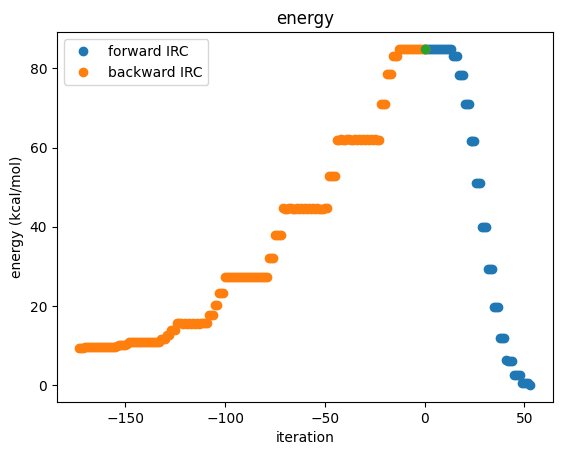

In [ ]:
from matplotlib import pyplot as plt
def plot_dft_energy(filename):
    """
    Function to find the energy in a psi4 optimization file.

    Usage: plot_energy(filename)

    Inputs: name of psi4 output file from geometry optimization calclaultion
    filename: name

    Output: list of energy values from each optimization step
    """

    with open(filename) as f:
        lines = f.readlines()
        #energy_string = 'Current energy'
        energy_values = [ float(line.split()[3]) for line in lines if line.strip().startswith('@DF-RKS Final') ]
        return energy_values
energy_values_f = np.array(plot_dft_energy('irc_forward.dat') )
energy_values_b = np.array(plot_dft_energy('irc_backward.dat'))
stepsf = len(energy_values_f)
stepsb = len(energy_values_b)

# plot the energies at each iteration
plt.figure()
plt.plot(range(stepsf),627.5*(energy_values_f-min(energy_values_f)),'o')
plt.plot([x*-1 for x in range(stepsb)],627.5*(energy_values_b-min(energy_values_f)),'o')
plt.plot(0,627.5*(ts_b3lyp_3_e - formald_b3lyp_3_e),'o')

plt.legend(['forward IRC','backward IRC'])
plt.xlabel("iteration")
plt.ylabel("energy (kcal/mol)")
plt.title('energy')
plt.savefig(F'IRC_DFT.png')


In [ ]:
def compute_rate_coeff(reactant_thermdicts, ts_thermdict):
    R = 1.987*10**(-3) # in kcal/molK
    ha_to_kcal = 627.509
    kb_div_h = 2.083661912*10**10 # Units of Hz/K
    full_dict = reactant_thermdicts.copy()
    full_dict.append(ts_thermdict)

    Temps = [thermdict['T'].data  for thermdict in full_dict]
    assert(len(set(Temps)) == 1) #Don't proceed if thermo dictionaries have mismatching temperatures.

    reac_g = sum(thermdict['G_tot'].data  for thermdict in reactant_thermdicts)
    ts_g = ts_thermdict['G_tot'].data
    #print(reac_g, ts_g)

    del_g_a = (ts_g - reac_g) * ha_to_kcal
    k = kb_div_h*Temps[0]*np.exp(- del_g_a / (R * Temps[0]))
    return k


forward barrier = 110.82639264095162 kcal/mol
reverse barrier = 98.86651042345783 kcal/mol
[2.6574649846580157e-63, 1.0813613822022634e-31, 4.368185125770515e-14, 0.0003049992411679109, 2.763632285060865, 25883.467998239248]
forward barrier = 91.26568198073583 kcal/mol
reverse barrier = 74.64432823460845 kcal/mol
[1.5365012640437376e-48, 7.267632796504131e-23, 1.6026435785213952e-08, 1.7805380673326663, 3101.680779605679, 5604227.478261203]
forward barrier = 84.93747338487287 kcal/mol
reverse barrier = 76.63226685379007 kcal/mol
[3.20447809976627e-44, 2.7097506177225424e-20, 6.350763239070599e-07, 20.06788909843535, 21044.48964121206, 22803788.66323197]
forward barrier = 141.332561297876 kcal/mol
reverse barrier = 134.19313982581542 kcal/mol
[3.509019535080689e-85, 9.557720084856169e-45, 2.97980501720194e-22, 1.0850992158343171e-09, 0.00012065395673224678, 13.947230893927648]
forward barrier = 112.00327117117494 kcal/mol
reverse barrier = 103.01222589055807 kcal/mol
[4.934587928999228e

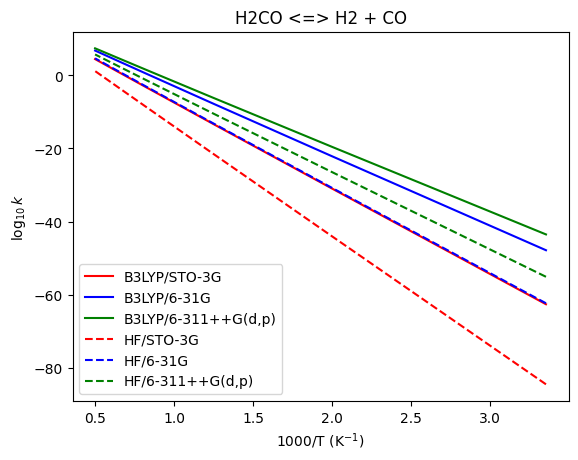

In [ ]:
#Now we can compute some barrier heights

b3lyp_lst = list(zip([ts_b3lyp_1_e,ts_b3lyp_2_e,ts_b3lyp_3_e,ts_hf_1_e,ts_hf_2_e,ts_hf_3_e],
                     [formald_b3lyp_1_e,formald_b3lyp_2_e,formald_b3lyp_3_e,formald_hf_1_e,formald_hf_2_e,formald_hf_3_e],
                     [co_b3lyp_1_e,co_b3lyp_2_e,co_b3lyp_3_e,co_hf_1_e,co_hf_2_e,co_hf_3_e],
                     [h2_b3lyp_1_e,h2_b3lyp_2_e,h2_b3lyp_3_e,h2_hf_1_e,h2_hf_2_e,h2_hf_3_e],
                     [ts_b3lyp_1_vibinfo,ts_b3lyp_2_vibinfo,ts_b3lyp_3_vibinfo,ts_hf_1_vibinfo,ts_hf_2_vibinfo,ts_hf_3_vibinfo],
                     [formald_b3lyp_1_vibinfo,formald_b3lyp_2_vibinfo,formald_b3lyp_3_vibinfo,formald_hf_1_vibinfo,formald_hf_2_vibinfo,formald_hf_3_vibinfo],
                     [co_b3lyp_1_vibinfo,co_b3lyp_2_vibinfo,co_b3lyp_3_vibinfo,co_hf_1_vibinfo,co_hf_2_vibinfo,co_hf_3_vibinfo],
                     [h2_b3lyp_1_vibinfo,h2_b3lyp_2_vibinfo,h2_b3lyp_3_vibinfo,h2_hf_1_vibinfo,h2_hf_2_vibinfo,h2_hf_3_vibinfo]))
colors = 2*['red','blue','green']
i = 0

kb_div_h = 2.083661912*10**10 # Units of Hz/K
ha_to_kcal = 627.509
R = 1.987*10**(-3) # in kcal/molK

for ts_decomp_e,formald_e,co_e,h2_e,ts_decomp_vibinfo,formald_vibinfo, co_vibinfo, h2_vibinfo in b3lyp_lst:

    forw_barr = (ts_decomp_e - formald_e) * ha_to_kcal
    forw_barr #https://doi.org/10.1021/jp982962m
    print('forward barrier = {} kcal/mol'.format(forw_barr))
    rev_barr = (ts_decomp_e - (co_e + h2_e)) * ha_to_kcal
    rev_barr
    print('reverse barrier = {} kcal/mol'.format(rev_barr))

    #To compute a rate constant, we will need to use the TST expression. ""For that, we need Free Energies.
    formald_thermdict = thermocalc(formaldehyde, formald_vibinfo, 298.15, 101325, formald_e)
    h2_dft_thermdict = thermocalc(h2, h2_vibinfo, 298.15, 101325, h2_e, 'RT_LINEAR')
    co_dft_thermdict = thermocalc(co, co_vibinfo, 298.15, 101325, co_e, 'RT_LINEAR')

    #Get the free energy of the transition state
    #ts_decomp_vibinfo = psi4.driver.vibanal_wfn(ts_decomp_wfn) # do the vibrational analysis for H2
    ts_decomp_thermdict = thermocalc(ts_decomp, ts_decomp_vibinfo, 298.15, 101325, ts_decomp_e)

    #Compute the rate constant
    T = 298.15

    ts_G = ts_decomp_thermdict['G_tot'].data
    formald_G = formald_thermdict['G_tot'].data

    k_for = kb_div_h * T * np.exp(-(ts_G - formald_G) * ha_to_kcal / (R*T))
    k_for

    k = compute_rate_coeff([formald_thermdict], ts_decomp_thermdict)
    k

    #Now, let's explore more temperatures.
    T_list = [298.15, 500, 800, 1200, 1500, 2000]

    k_decomps = []

    for T in T_list:
        formald_thermdict = thermocalc(formaldehyde, formald_vibinfo, T, 101325, formald_e)
        ts_thermdict = thermocalc(ts_decomp, ts_decomp_vibinfo, T, 101325, ts_decomp_e)
        k = compute_rate_coeff([formald_thermdict], ts_thermdict)
        k_decomps.append(k)

    print(k_decomps)
    if i<3:
        plt.plot(1/np.asarray(T_list)*1000, np.log10(k_decomps),c = colors[i])
    else:
        plt.plot(1/np.asarray(T_list)*1000, np.log10(k_decomps),'--',c = colors[i])
    i+=1


plt.xlabel('1000/T (K$^{-1}$)')
plt.ylabel('$\log_{10}k$')
plt.title('H2CO <=> H2 + CO')
plt.xlabel('1000/T (K$^{-1}$)')
plt.ylabel('$\log_{10}k$')
plt.title('H2CO <=> H2 + CO')
plt.legend(['B3LYP/STO-3G','B3LYP/6-31G','B3LYP/6-311++G(d,p)','HF/STO-3G','HF/6-31G','HF/6-311++G(d,p)'])